# **Diabetes Mellitus *DNA Classification* using Machine Learning**
Here we will classify the DM DNA based on the sequences using conventional Machine Learning algorithm:
NuSVC
XGBoost.

## Import libraries and set up environment

In [ ]:
# import librabries required
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

import os
import warnings
warnings.filterwarnings('ignore')

## Read DNA Files

In [ ]:
# load dataset from github
def load_data(url):
  filepath = os.path.join(url, '?raw=true')
  data = pd.read_csv(filepath)
  return data

url = 'https://github.com/mobilttterbang/DNA_Classification_Project/blob/main/dataset/SKRIPSI_Data_DM_DNA_Sequence.csv'

DNA = load_data(url)
DNA.head()

,sequence,length,class
0,AATAATTTGTGCACTTCAGAATATTCTACAATAATATATTATTTCC...,1010,DMT2
1,AGTCCTTCGCCGTCCCTCGCCGTCCTTCGCCATCGCACGCCACCGC...,1010,DMT2
2,AGTCCTTCGCCGTCCCTCGCCGTCCTTCGCCATCGCACGCCACCGC...,1013,DMT2
3,AGTTGGAGTCTCCAGGGATCAGGGTTCCAGGAACTCAGGATCTGCA...,1013,DMT2
4,AGTCCTTCGCCGTCCCTCGCCGTCCTTCGCCATCGCACGCCACCGC...,1015,DMT2


In [ ]:
# check data distrbution in each classes
DNA['class'].value_counts()

class
NONDM    989
DMT2     443
DMT1     145
Name: count, dtype: int64

In [ ]:
# shape of the dataset
DNA.shape

(1577, 3)

## Preprocessing DNA dataset
here we will do preprocessing in the DNA sequence dataset (k-mers => bag-of-words => CountVectorizer and TF-IDF)

### K-Mers

In [ ]:
# define k-mers function to split the sequence into group of k-mers words
def getKmers(sequence, size=3):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

# apply the k-mers function
DNA['k-mers'] = DNA.apply(lambda x: getKmers(x['sequence']), axis=1)
DNA[['sequence','k-mers']].head()

,sequence,k-mers
0,AATAATTTGTGCACTTCAGAATATTCTACAATAATATATTATTTCC...,"[aat, ata, taa, aat, att, ttt, ttg, tgt, gtg, ..."
1,AGTCCTTCGCCGTCCCTCGCCGTCCTTCGCCATCGCACGCCACCGC...,"[agt, gtc, tcc, cct, ctt, ttc, tcg, cgc, gcc, ..."
2,AGTCCTTCGCCGTCCCTCGCCGTCCTTCGCCATCGCACGCCACCGC...,"[agt, gtc, tcc, cct, ctt, ttc, tcg, cgc, gcc, ..."
3,AGTTGGAGTCTCCAGGGATCAGGGTTCCAGGAACTCAGGATCTGCA...,"[agt, gtt, ttg, tgg, gga, gag, agt, gtc, tct, ..."
4,AGTCCTTCGCCGTCCCTCGCCGTCCTTCGCCATCGCACGCCACCGC...,"[agt, gtc, tcc, cct, ctt, ttc, tcg, cgc, gcc, ..."


In [ ]:
len(DNA['k-mers'][0])
# len(DNA['sequence'][0])

1008

In [ ]:
# here we will split the data into 2 variables : features and targets
# DNA features
DNA_features = list(DNA['k-mers'])
for item in range(len(DNA_features)):
    DNA_features[item] = ' '.join(DNA_features[item])
print(f'DNA features samples : {DNA_features[0][0:100]}')
print('')

# DNA targets
DNA_targets = DNA['class'].copy()
print(f'DNA targets samples :')
print(f'{DNA_targets.sample(6)}')

DNA features samples : aat ata taa aat att ttt ttg tgt gtg tgc gca cac act ctt ttc tca cag aga gaa aat ata tat att ttc tct 

DNA targets samples :
1123    NONDM
988     NONDM
137      DMT2
92       DMT1
554     NONDM
1116    NONDM
Name: class, dtype: object


### Count Vectorizer


In [ ]:
# transform the k-mers sequences using CountVectorizer with the bag-of-words = 4
# define the vectorizer
cv = CountVectorizer(ngram_range=(4, 4))

# apply the transformation
DNA_features_CV = cv.fit_transform(DNA_features)

# result samples
DNA_features_CV[0:100].toarray()

array([[1, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [5, 2, 0, ..., 1, 0, 1]])

In [ ]:
# see the length of the feature
print(f'the features after using bag-of-words is {DNA_features_CV.shape[1]}')
print('')

# see the 0-25 features name
print(f'0-11 features name : {cv.get_feature_names_out()[0:11]}')

the features after using bag-of-words is 4096

0-11 features name : ['aaa aaa aaa aaa' 'aaa aaa aaa aac' 'aaa aaa aaa aag' 'aaa aaa aaa aat'
 'aaa aaa aac aca' 'aaa aaa aac acc' 'aaa aaa aac acg' 'aaa aaa aac act'
 'aaa aaa aag aga' 'aaa aaa aag agc' 'aaa aaa aag agg']


In [ ]:
DNA_features_CV[0].toarray()

array([[1, 1, 0, ..., 0, 0, 0]])

### Transform DNA targets to Numeric

In [ ]:
le = LabelEncoder()
DNA_targets = le.fit_transform(DNA_targets)
DNA_targets

array([1, 1, 1, ..., 0, 1, 1])

### Oversampling the Data
since the dataset we have is still imbalanced

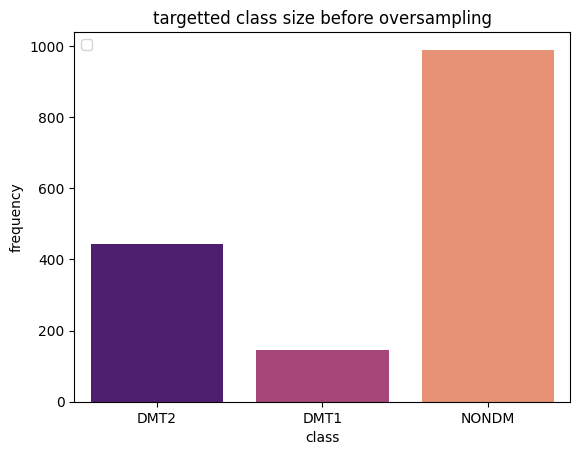

In [ ]:
# plot the DNA targets
sns.countplot(data = DNA, x = 'class', palette = 'magma', legend=True)
plt.title('targetted class size before oversampling')
plt.xlabel('class')
plt.ylabel('frequency')
plt.legend()
plt.show()

In [ ]:
# oversample the data using SMOTE
sm = SMOTE(random_state=42, sampling_strategy='not majority')
DNA_features_oversampled, DNA_targets_oversampled = sm.fit_resample(DNA_features_CV, DNA_targets)

In [ ]:
targets = pd.DataFrame(DNA_targets_oversampled)
targets.columns = ['class']

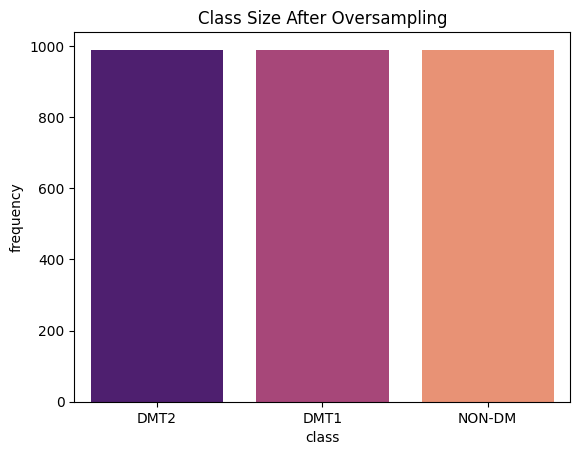



Total data after OVERSAMPLED: 2967 data



In [ ]:
# plot the DNA targets
plot = sns.countplot(targets, x = 'class', palette = 'magma')
plt.title('Class Size After Oversampling')
plt.xlabel('class')
plt.ylabel('frequency')
plot.set_xticklabels(['DMT2', 'DMT1', 'NON-DM'])
plt.show()

print()
print()
print(f"Total data after OVERSAMPLED: {len(targets)} data")
print()

### Split the Dataset into train and test data
here we will split the data into 80% training data and 20% test data

In [ ]:
# split data again
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(DNA_features_oversampled, DNA_targets_oversampled, stratify = DNA_targets_oversampled, test_size = 0.20, random_state=42)

## **Hyperplane Trial (Still Error)**

In [ ]:
from sklearn.svm import NuSVC
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from mpl_toolkits.mplot3d import Axes3D

# Apply PCA to reduce dimensionality to 2 or 3 components
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_test.toarray())
X_reduced


array([[ 18.9154502 ,  52.6515897 ],
       [  0.90900451, -13.19656798],
       [ 41.0665326 , -18.52314594],
       ...,
       [  4.02234361,  37.73452769],
       [ 10.78918185, -30.64448337],
       [-39.4809472 , -14.06551317]])

In [ ]:
# Train an SVM classifier
svm = NuSVC(nu=0.05, kernel='linear')
svm.fit(X_reduced, y_test)

NuSVC(kernel='linear', nu=0.05)

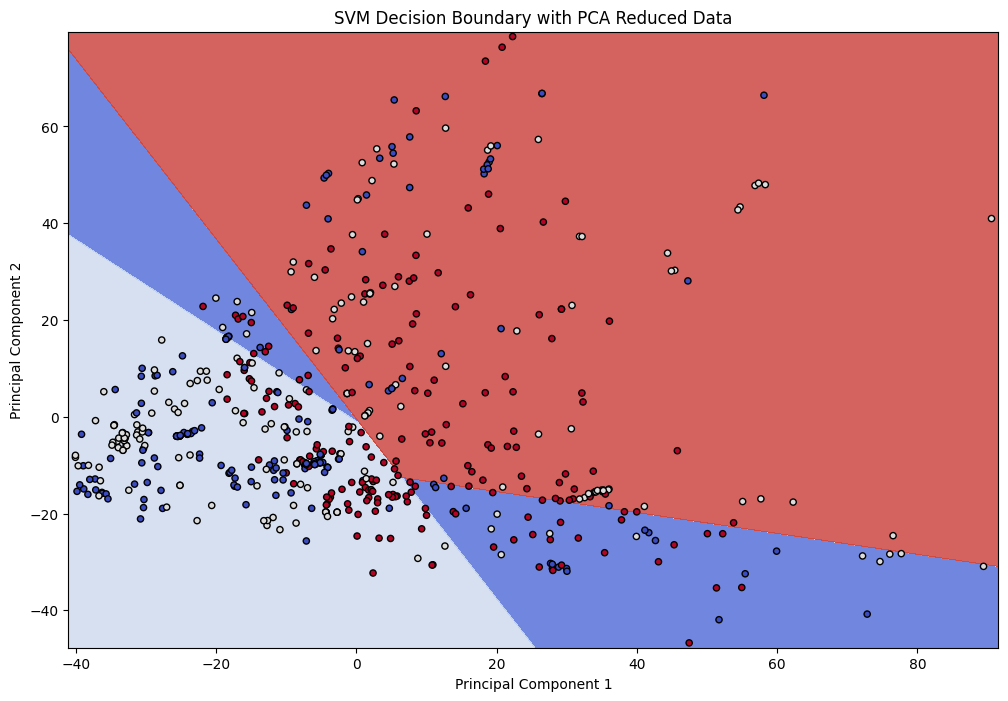

In [ ]:
# Create a mesh to plot the decision boundaries
h = .02  # step size in the mesh
x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Predict the function value for the whole grid
Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plotting
plt.figure(figsize=(12, 8))
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_test, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('SVM Decision Boundary with PCA Reduced Data')
plt.show()

## Machine Learning Process

### NuSVC

In [ ]:
# # HYPERPARAMETER TUNING

# from sklearn.svm import NuSVC
# from sklearn.model_selection import GridSearchCV

# # defining parameter range
# param_grid = {'nu': [0.01, 0.05, 0.001],
#                'gamma': [0.1, 0.01],
#                'kernel' : ['linear', 'rbf', 'poly']}

# grid = GridSearchCV(NuSVC(), param_grid, refit = True, verbose = 3, cv = 3)

# # fitting the model for grid search
# grid.fit(X_train, y_train)
# grid.best_params_

In [ ]:
from sklearn.svm import NuSVC

# define the model
cf = NuSVC(nu=0.05, kernel='linear')

# fit the model
cf.fit(X_train,y_train)

# predict data using model
predicted = cf.predict(X_test)

# model performance 01
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89       198
           1       0.84      0.89      0.87       198
           2       0.98      0.95      0.96       198

    accuracy                           0.91       594
   macro avg       0.91      0.91      0.91       594
weighted avg       0.91      0.91      0.91       594



In [ ]:
print(f"Alpha not in a contsraint (a > 1/m):{(np.abs(cf.dual_coef_).toarray() > (1/len(targets))).sum()}")

Alpha not in a contsraint (a > 1/m):587


In [ ]:
print(f"jumlah suppport vektor pada tiap kelas")
print(f"SV kelas 0: {cf.n_support_[0]}")
print(f"SV kelas 1: {cf.n_support_[1]}")
print(f"SV kelas 2: {cf.n_support_[2]}")

jumlah suppport vektor pada tiap kelas
SV kelas 0: 231
SV kelas 1: 302
SV kelas 2: 310


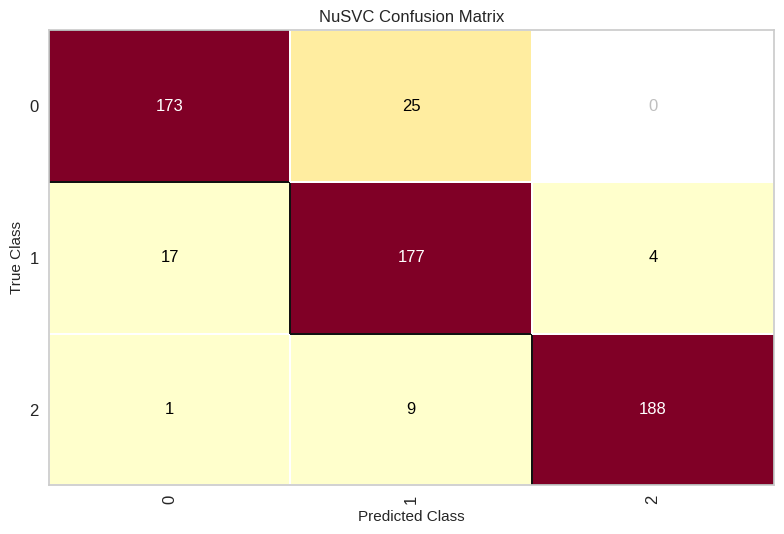

<Axes: title={'center': 'NuSVC Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [ ]:
# evaluation
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ROCAUC
from yellowbrick.style import set_palette

cfmatrix = ConfusionMatrix(cf)

cfmatrix.fit(X_train, y_train)
cfmatrix.score(X_test, y_test)
cfmatrix.show()

In [ ]:
from sklearn.svm import NuSVC
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Assuming you have your dataset X and labels y

# Specify the number of splits and repeats
n_splits = 5  # Number of folds
n_repeats = 1  # Number of repeats

# Specify NuSVC parameters
nu_value = 0.05

# Create a RepeatedStratifiedKFold object
rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

# Initialize NuSVC with linear kernel and specified parameters
model = NuSVC(kernel='linear', nu=nu_value)

acc = []
prec = []
rec = []
f1score = []

# Perform repeated stratified cross-validation
for train_index, test_index in rskf.split(DNA_features_oversampled, DNA_targets_oversampled):
    X_train, X_test = DNA_features_oversampled[train_index], DNA_features_oversampled[test_index]
    y_train, y_test = DNA_targets_oversampled[train_index], DNA_targets_oversampled[test_index]

    # Train the NuSVC model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = model.predict(X_test)

    # Evaluate accuracy
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average="macro")
    recall = recall_score(y_test, predictions, average="macro")
    f1 = f1_score(y_test, predictions, average="macro")

    acc.append(accuracy)
    prec.append(precision)
    rec.append(recall)
    f1score.append(f1)

    print(f"Accuracy:{accuracy}, Precision:{precision}, Recall:{recall}, F1:{f1}")

print(f"Average accuracy : {np.mean(acc)}")
print(f"Average precision : {np.mean(prec)}")
print(f"Average recall : {np.mean(rec)}")
print(f"Average f1 score : {np.mean(f1score)}")

Accuracy:0.9090909090909091, Precision:0.9108059951787024, Recall:0.9090909090909092, F1:0.9096429909681754
Accuracy:0.9158249158249159, Precision:0.9163588913598146, Recall:0.9158249158249158, F1:0.9157415257305085
Accuracy:0.9190556492411467, Precision:0.9217128118198561, Recall:0.9191235536413201, F1:0.9189342400132533
Accuracy:0.8768971332209107, Precision:0.8816300057739918, Recall:0.8767369122699072, F1:0.8767381669432437
Accuracy:0.8718381112984823, Precision:0.8782836254717074, Recall:0.8718573210958999, F1:0.8729710625521233
Average accuracy : 0.898541343735273
Average precision : 0.9017582659208145
Average recall : 0.8985267223845904
Average f1 score : 0.8988055972414608


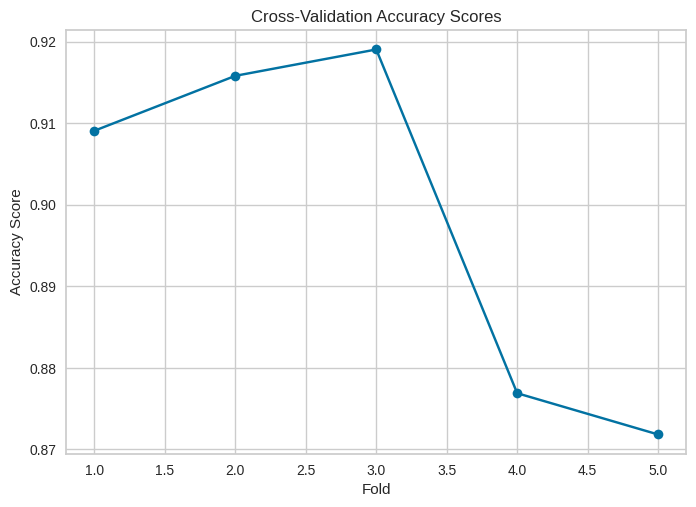

In [ ]:
# Plotting the accuracy scores
plt.plot(range(1, len(acc) + 1), acc, marker='o')
plt.title('Cross-Validation Accuracy Scores')
plt.xlabel('Fold')
plt.ylabel('Accuracy Score')
plt.show()